### Here I will show you how to change atomic function in Atomic KANLayer to other atomic function. All of them are in the file kernel.py, so you can just do some experiments with them. Don't forget about heperparameters like "m", "n", and "a". Good luck)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from AtomicKANLayer import AtomicKANLayer
import torch
import torch.nn as nn
from kernel import *

In [2]:
class AtomicKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree, input_range=(-1, 1)):
        super(AtomicKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree
        self.input_range = input_range

        self.atomic_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.atomic_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

        self.register_buffer("centers", torch.linspace(input_range[0], input_range[1], degree + 1))

        center_spacing = (input_range[1] - input_range[0]) / degree
        compression_value = 1.0 / center_spacing  # Для 50% перекрытия

        self.compression = nn.Parameter(torch.ones(degree + 1) * compression_value)

        self.nsum = 100
        self.nprod = 10

    def forward(self, x):
        x = x.view(-1, self.inputdim, 1)
        centers = self.centers.view(1, 1, -1)
        compression = self.compression.view(1, 1, -1)
        scaled_x = (x - centers) * compression

        atomic_basis = fupn(scaled_x, n=1, nsum=self.nsum, nprod=self.nprod) # <-- change this function to other in the file kernel.py!!!

        y = torch.einsum("bid,iod->bo", atomic_basis, self.atomic_coeffs)
        return y.view(-1, self.outdim)

In [3]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 10,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.dpi': 300
})

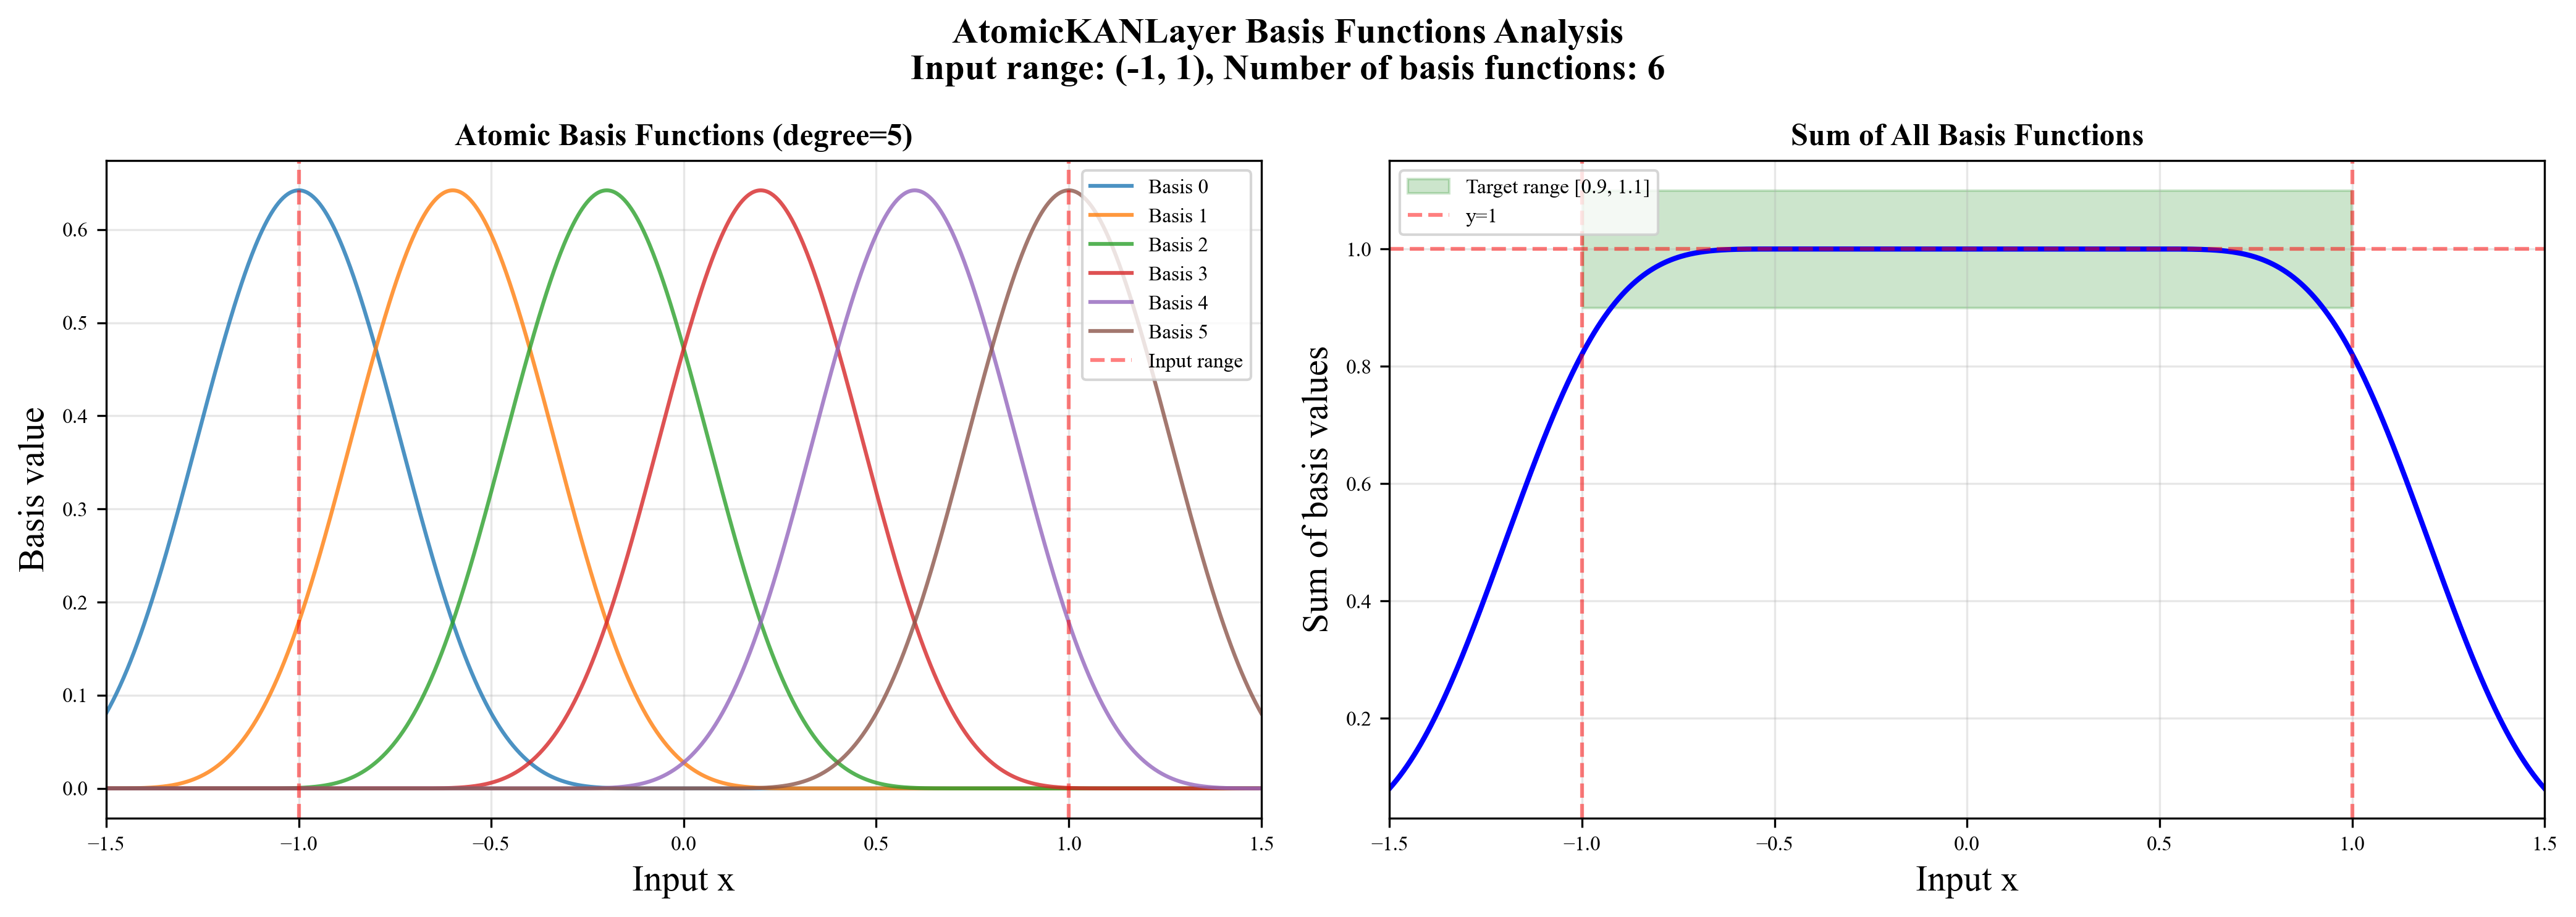

In [4]:
def visualize_atomic_basis():
    # Параметры слоя для визуализации
    input_range = (-1, 1)
    degree = 5  # Количество базисных функций - 1
    nsum = 100
    nprod = 10

    # Создаем слой для анализа
    layer = AtomicKANLayer(
        input_dim=1,  # Для визуализации достаточно 1D входа
        output_dim=1,  # Для визуализации достаточно 1D выхода
        degree=degree,
        input_range=input_range
    )

    # Переводим слой в режим оценки (не обучения)
    layer.eval()

    # Создаем входные данные для визуализации
    x = torch.linspace(input_range[0] - 0.5, input_range[1] + 0.5, 1000)
    x_grid = x.view(-1, 1, 1)  # Формат: (batch, input_dim, 1)

    # Получаем центры и параметры сжатия
    centers = layer.centers.view(1, 1, -1)
    compression = layer.compression.view(1, 1, -1)

    # Вычисляем масштабированные значения
    scaled_x = (x_grid - centers) * compression

    # Вычисляем базисные функции (с torch.no_grad() для отключения градиентов)
    with torch.no_grad():
        atomic_basis = fupn(scaled_x, n=1, nsum=nsum, nprod=nprod)

    # Преобразуем в numpy для визуализации с использованием detach()
    x_np = x.detach().numpy()
    atomic_basis_np = atomic_basis.squeeze().detach().numpy()  # Формат: (1000, degree+1)
    centers_np = layer.centers.detach().numpy()

    # Создаем фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Все базисные функции вместе
    for i in range(degree + 1):
        ax1.plot(x_np, atomic_basis_np[:, i], label=f'Basis {i}', alpha=0.8)
    ax1.axvline(input_range[0], color='r', linestyle='--', alpha=0.5, label='Input range')
    ax1.axvline(input_range[1], color='r', linestyle='--', alpha=0.5)
    ax1.set_title(f'Atomic Basis Functions (degree={degree})', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Input x')
    ax1.set_ylabel('Basis value')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=8)

    # 2. Сумма всех базисных функций (должна быть примерно 1 в рабочей области)
    sum_basis = atomic_basis_np.sum(axis=1)
    ax2.plot(x_np, sum_basis, 'b-', linewidth=2)
    ax2.fill_between(x_np, 0.9, 1.1, where=((x_np >= input_range[0]) & (x_np <= input_range[1])),
                     alpha=0.2, color='green', label='Target range [0.9, 1.1]')
    ax2.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='y=1')
    ax2.axvline(input_range[0], color='r', linestyle='--', alpha=0.5)
    ax2.axvline(input_range[1], color='r', linestyle='--', alpha=0.5)
    ax2.set_title('Sum of All Basis Functions', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Input x')
    ax2.set_ylabel('Sum of basis values')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')

    # Устанавливаем одинаковые пределы по x для обоих графиков
    x_min = input_range[0] - 0.5
    x_max = input_range[1] + 0.5
    ax1.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)

    plt.suptitle(f'AtomicKANLayer Basis Functions Analysis\n'
                 f'Input range: {input_range}, Number of basis functions: {degree + 1}',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Запуск визуализации
visualize_atomic_basis()

In [6]:
class AtomicKANLayer(nn.Module): # UP function instead of FUPN
    def __init__(self, input_dim, output_dim, degree, input_range=(-1, 1)):
        super(AtomicKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree
        self.input_range = input_range

        self.atomic_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.atomic_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

        self.register_buffer("centers", torch.linspace(input_range[0], input_range[1], degree + 1))

        center_spacing = (input_range[1] - input_range[0]) / degree
        compression_value = 1.0 / center_spacing

        self.compression = nn.Parameter(torch.ones(degree + 1) * compression_value)

        self.nsum = 100
        self.nprod = 10

    def forward(self, x):
        x = x.view(-1, self.inputdim, 1)
        centers = self.centers.view(1, 1, -1)
        compression = self.compression.view(1, 1, -1)
        scaled_x = (x - centers) * compression

        atomic_basis = up(scaled_x, nsum=self.nsum, nprod=self.nprod) # <-- change this function to other in the file kernel.py!!!

        y = torch.einsum("bid,iod->bo", atomic_basis, self.atomic_coeffs)
        return y.view(-1, self.outdim)

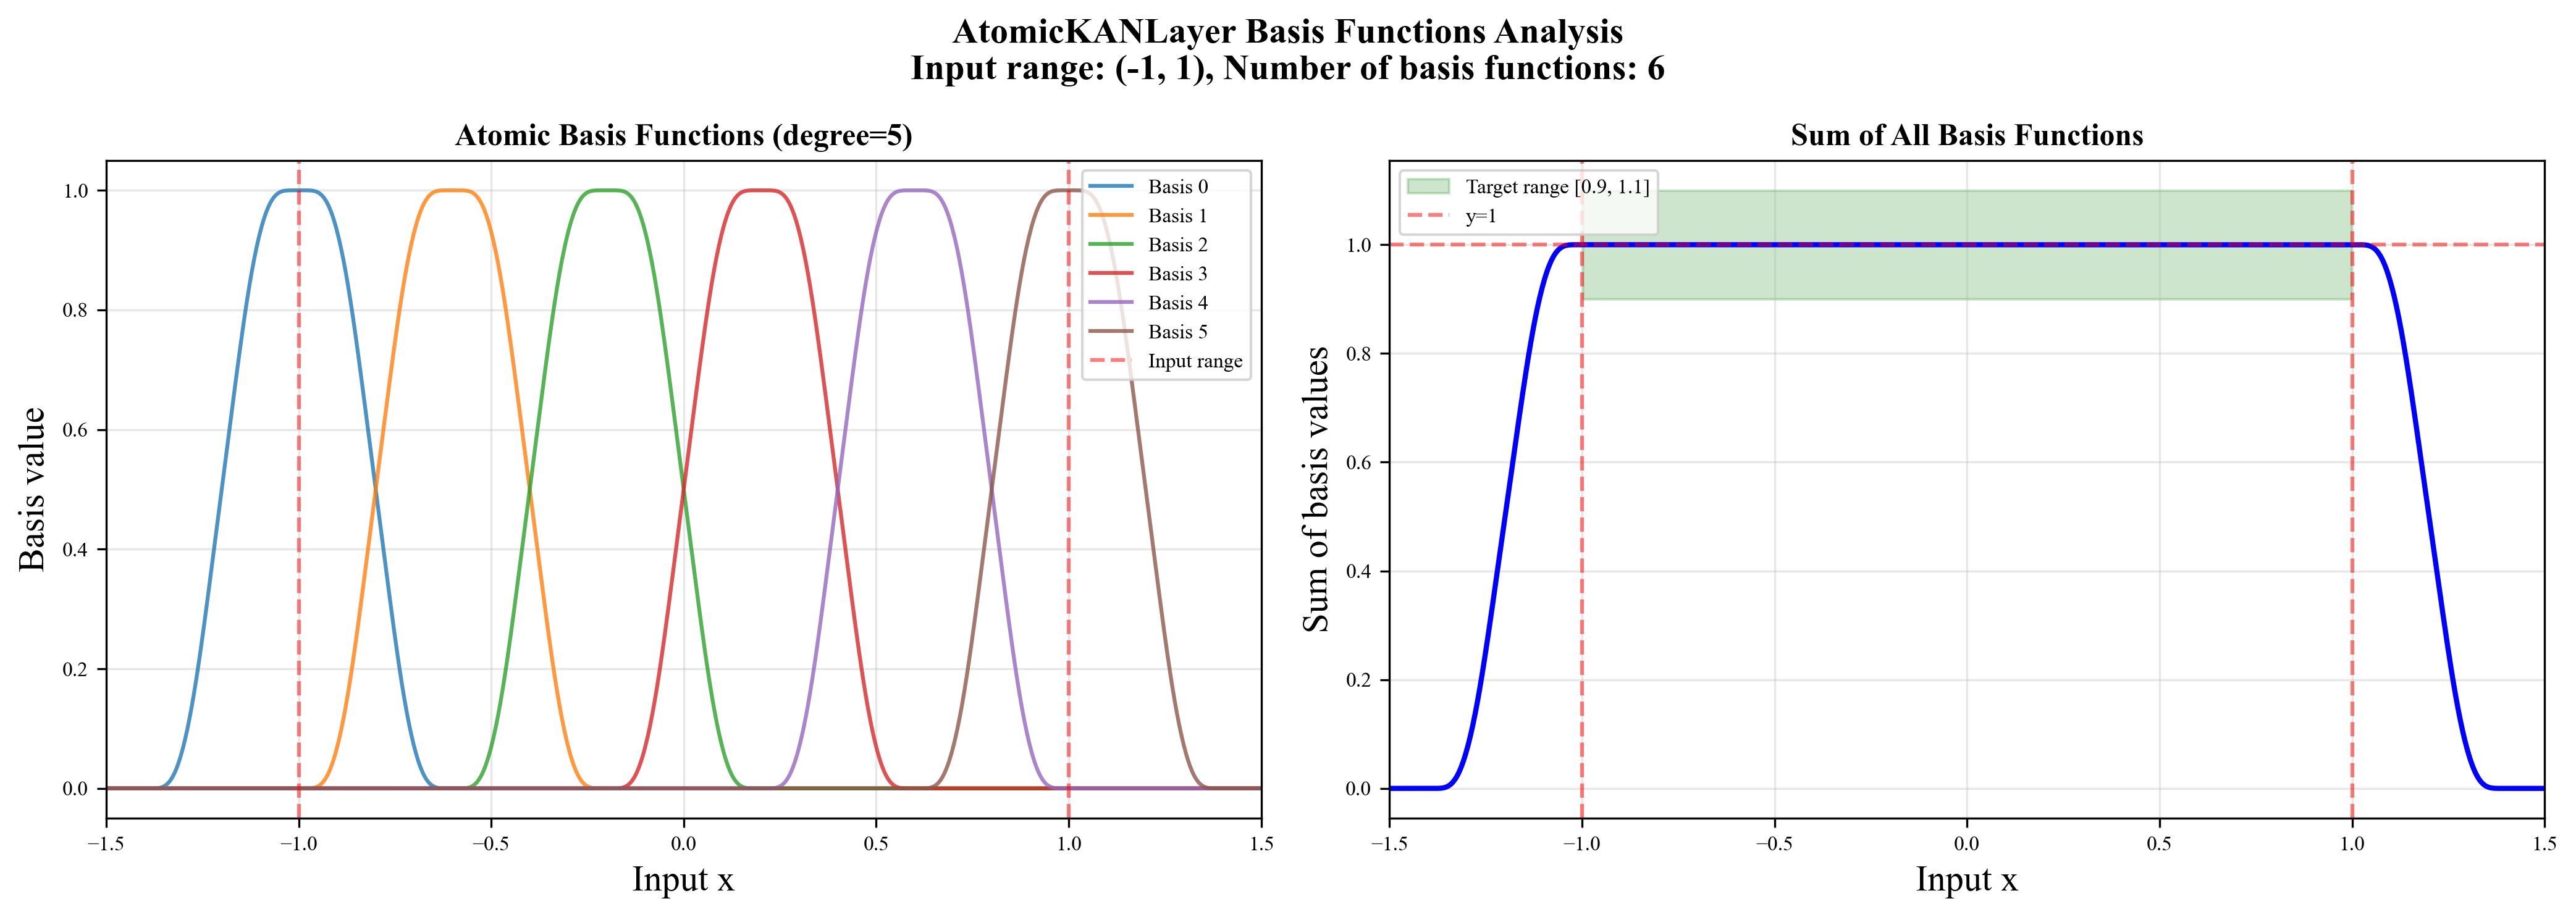

In [7]:
def visualize_atomic_basis():
    # Параметры слоя для визуализации
    input_range = (-1, 1)
    degree = 5  # Количество базисных функций - 1
    nsum = 100
    nprod = 10

    # Создаем слой для анализа
    layer = AtomicKANLayer(
        input_dim=1,  # Для визуализации достаточно 1D входа
        output_dim=1,  # Для визуализации достаточно 1D выхода
        degree=degree,
        input_range=input_range
    )

    # Переводим слой в режим оценки (не обучения)
    layer.eval()

    # Создаем входные данные для визуализации
    x = torch.linspace(input_range[0] - 0.5, input_range[1] + 0.5, 1000)
    x_grid = x.view(-1, 1, 1)  # Формат: (batch, input_dim, 1)

    # Получаем центры и параметры сжатия
    centers = layer.centers.view(1, 1, -1)
    compression = layer.compression.view(1, 1, -1)

    # Вычисляем масштабированные значения
    scaled_x = (x_grid - centers) * compression

    # Вычисляем базисные функции (с torch.no_grad() для отключения градиентов)
    with torch.no_grad():
        atomic_basis = up(scaled_x, nsum=nsum, nprod=nprod)

    # Преобразуем в numpy для визуализации с использованием detach()
    x_np = x.detach().numpy()
    atomic_basis_np = atomic_basis.squeeze().detach().numpy()  # Формат: (1000, degree+1)
    centers_np = layer.centers.detach().numpy()

    # Создаем фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Все базисные функции вместе
    for i in range(degree + 1):
        ax1.plot(x_np, atomic_basis_np[:, i], label=f'Basis {i}', alpha=0.8)
    ax1.axvline(input_range[0], color='r', linestyle='--', alpha=0.5, label='Input range')
    ax1.axvline(input_range[1], color='r', linestyle='--', alpha=0.5)
    ax1.set_title(f'Atomic Basis Functions (degree={degree})', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Input x')
    ax1.set_ylabel('Basis value')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=8)

    # 2. Сумма всех базисных функций (должна быть примерно 1 в рабочей области)
    sum_basis = atomic_basis_np.sum(axis=1)
    ax2.plot(x_np, sum_basis, 'b-', linewidth=2)
    ax2.fill_between(x_np, 0.9, 1.1, where=((x_np >= input_range[0]) & (x_np <= input_range[1])),
                     alpha=0.2, color='green', label='Target range [0.9, 1.1]')
    ax2.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='y=1')
    ax2.axvline(input_range[0], color='r', linestyle='--', alpha=0.5)
    ax2.axvline(input_range[1], color='r', linestyle='--', alpha=0.5)
    ax2.set_title('Sum of All Basis Functions', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Input x')
    ax2.set_ylabel('Sum of basis values')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')

    # Устанавливаем одинаковые пределы по x для обоих графиков
    x_min = input_range[0] - 0.5
    x_max = input_range[1] + 0.5
    ax1.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)

    plt.suptitle(f'AtomicKANLayer Basis Functions Analysis\n'
                 f'Input range: {input_range}, Number of basis functions: {degree + 1}',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Запуск визуализации
visualize_atomic_basis()

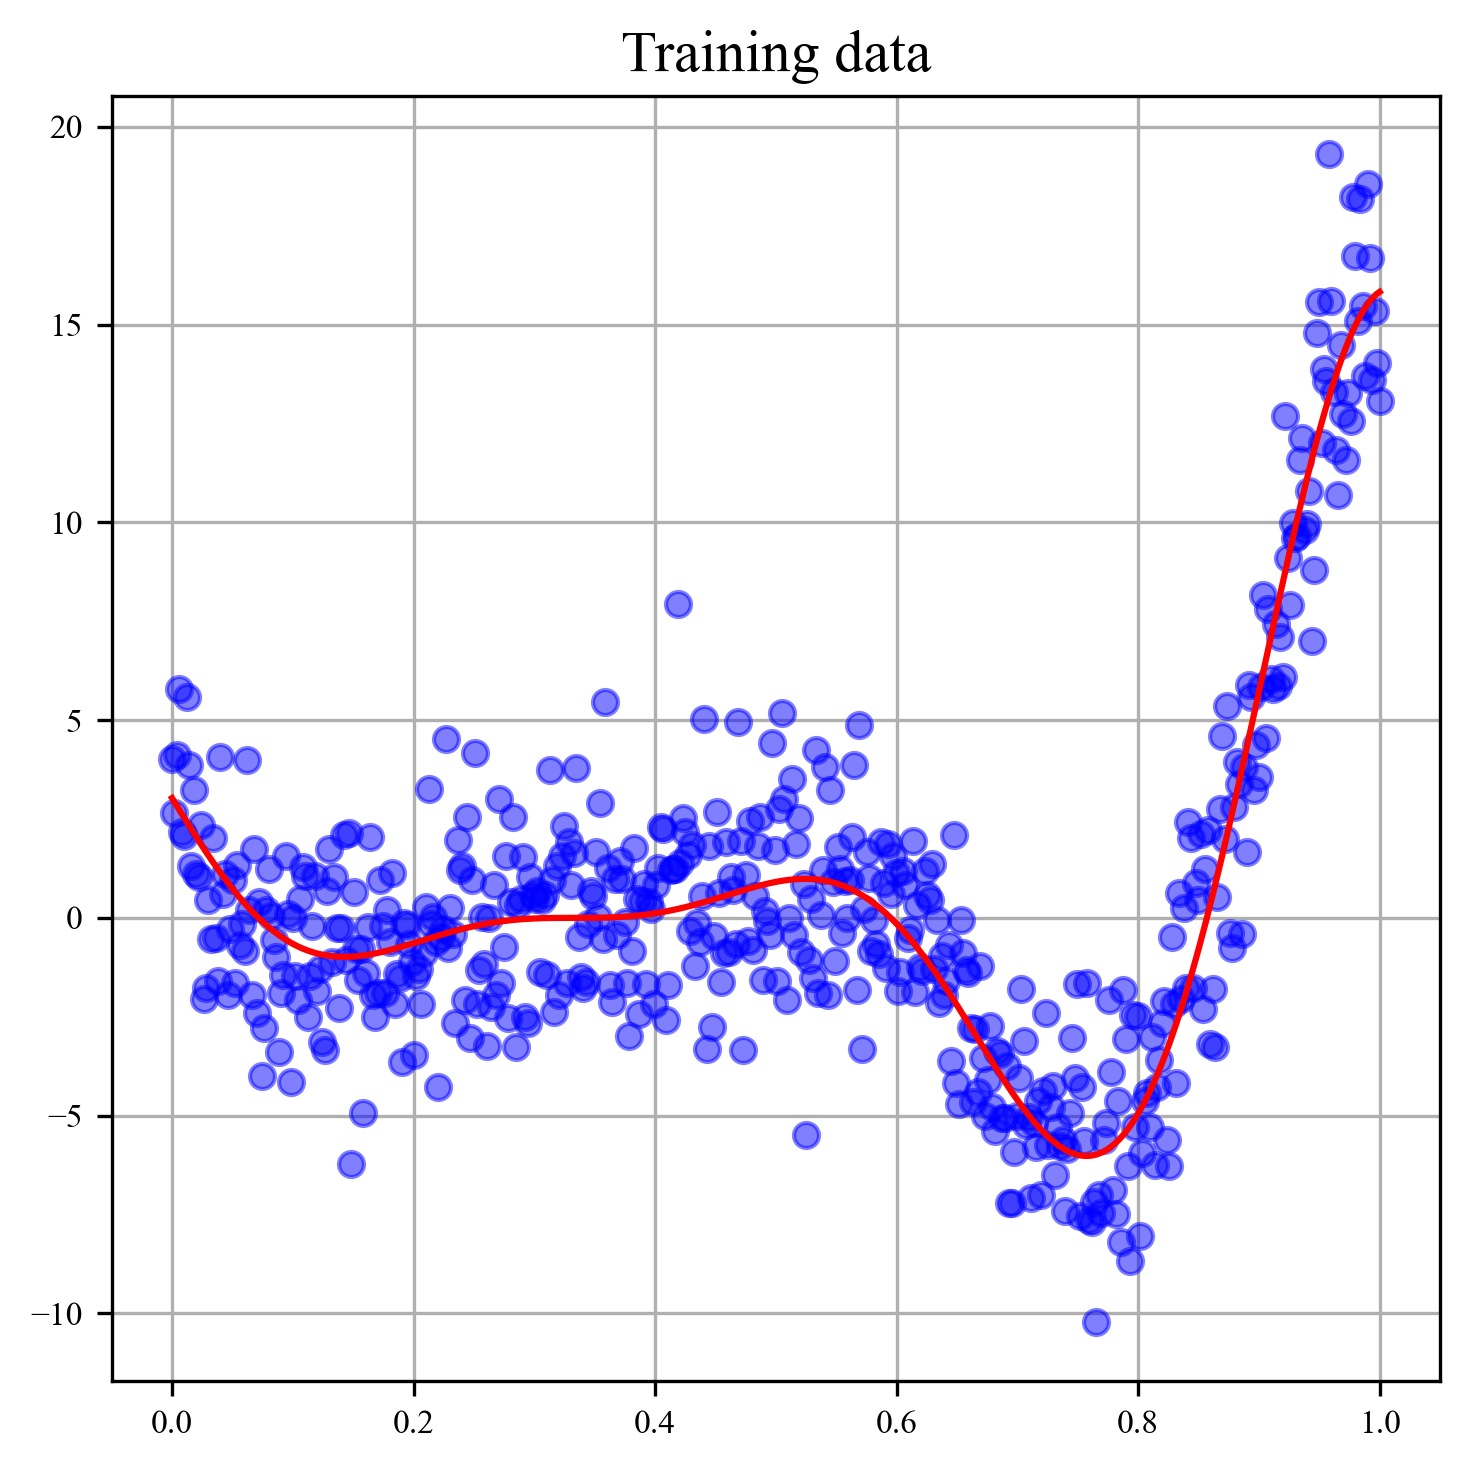

In [8]:
np.random.seed(42)
torch.manual_seed(42)

def target_function(x):
    # Преобразуем тензор в numpy массив явно
    x_np = x.numpy() if isinstance(x, torch.Tensor) else np.asarray(x, dtype=np.float64)
    y = (6 * x_np - 2) ** 2 * np.sin(12 * x_np - 4)
    # Добавляем шум
    noise = np.random.normal(0, 2, y.shape)
    y += noise
    return y

def target_function2(x):
    # Преобразуем тензор в numpy массив явно
    x_np = x.numpy() if isinstance(x, torch.Tensor) else np.asarray(x, dtype=np.float64)
    y = (6 * x_np - 2) ** 2 * np.sin(12 * x_np - 4)
    return y

# Создаем данные
x_train = torch.linspace(0, 1, 500).unsqueeze(1)

# Правильное создание тензоров без предупреждений
# Вариант 1: Используем torch.from_numpy()
x_train_np = x_train.numpy()
y_train_np = target_function(x_train_np)
y_train = torch.from_numpy(y_train_np).float()

# Или вариант 2: Создаем напрямую
# y_train = torch.tensor(target_function(x_train_np), dtype=torch.float32)

# Визуализация
fig, ax = plt.subplots(figsize=(5,5))

# Преобразуем для построения графика
x_plot = x_train.squeeze().numpy()
y_plot = y_train.squeeze().numpy()

ax.plot(x_plot, y_plot, 'o', color='blue', alpha=0.5)
ax.plot(x_plot, target_function2(x_plot), '-', color='red')
ax.set_title('Training data')
ax.grid()
fig.tight_layout()
plt.show()

In [9]:

class AtomicKAN(nn.Module):
    def __init__(self):
        super(AtomicKAN, self).__init__()
        self.atomkan1 = AtomicKANLayer(1, 8, 8)
        self.atomkan2 = AtomicKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.atomkan1(x)
        x = self.atomkan2(x)
        return x

# Instantiate models
atomic_model = AtomicKAN()

# Define loss_bspline function and optimizer_bspline
criterion = nn.MSELoss()
optimizer_atom = torch.optim.Adam(atomic_model.parameters(), lr=0.01)

atom_losses = []


# Train the models
# epochs = 200000
epochs = 300
epoch_step = 10
for epoch in range(epochs):
    optimizer_atom.zero_grad()
    outputs_atom = atomic_model(x_train)
    loss_atom = criterion(outputs_atom, y_train)
    loss_atom.backward()
    optimizer_atom.step()




    if epoch % epoch_step == 0:
        atom_losses.append(loss_atom.item())
        print(f'Epoch {epoch + 1}/{epochs}, AtomicKAN Loss: {loss_atom.item():.4f}')

# Test the models
x_test = torch.linspace(0, 1, steps=400).unsqueeze(1)
# x_test = torch.linspace(-1, 1, steps=400).unsqueeze(1)
y_pred_atom = atomic_model(x_test).detach()

Epoch 1/300, AtomicKAN Loss: 23.4978
Epoch 11/300, AtomicKAN Loss: 20.2250
Epoch 21/300, AtomicKAN Loss: 17.2102
Epoch 31/300, AtomicKAN Loss: 14.7106
Epoch 41/300, AtomicKAN Loss: 12.6364
Epoch 51/300, AtomicKAN Loss: 10.7460
Epoch 61/300, AtomicKAN Loss: 8.9776
Epoch 71/300, AtomicKAN Loss: 7.3672
Epoch 81/300, AtomicKAN Loss: 6.1449
Epoch 91/300, AtomicKAN Loss: 5.2649
Epoch 101/300, AtomicKAN Loss: 4.6620
Epoch 111/300, AtomicKAN Loss: 4.2730
Epoch 121/300, AtomicKAN Loss: 4.0331
Epoch 131/300, AtomicKAN Loss: 3.8927
Epoch 141/300, AtomicKAN Loss: 3.8097
Epoch 151/300, AtomicKAN Loss: 3.7573
Epoch 161/300, AtomicKAN Loss: 3.7234
Epoch 171/300, AtomicKAN Loss: 3.7018
Epoch 181/300, AtomicKAN Loss: 3.6855
Epoch 191/300, AtomicKAN Loss: 3.6691
Epoch 201/300, AtomicKAN Loss: 3.6551
Epoch 211/300, AtomicKAN Loss: 3.6467
Epoch 221/300, AtomicKAN Loss: 3.6390
Epoch 231/300, AtomicKAN Loss: 3.6267
Epoch 241/300, AtomicKAN Loss: 3.6178
Epoch 251/300, AtomicKAN Loss: 3.6129
Epoch 261/300, At

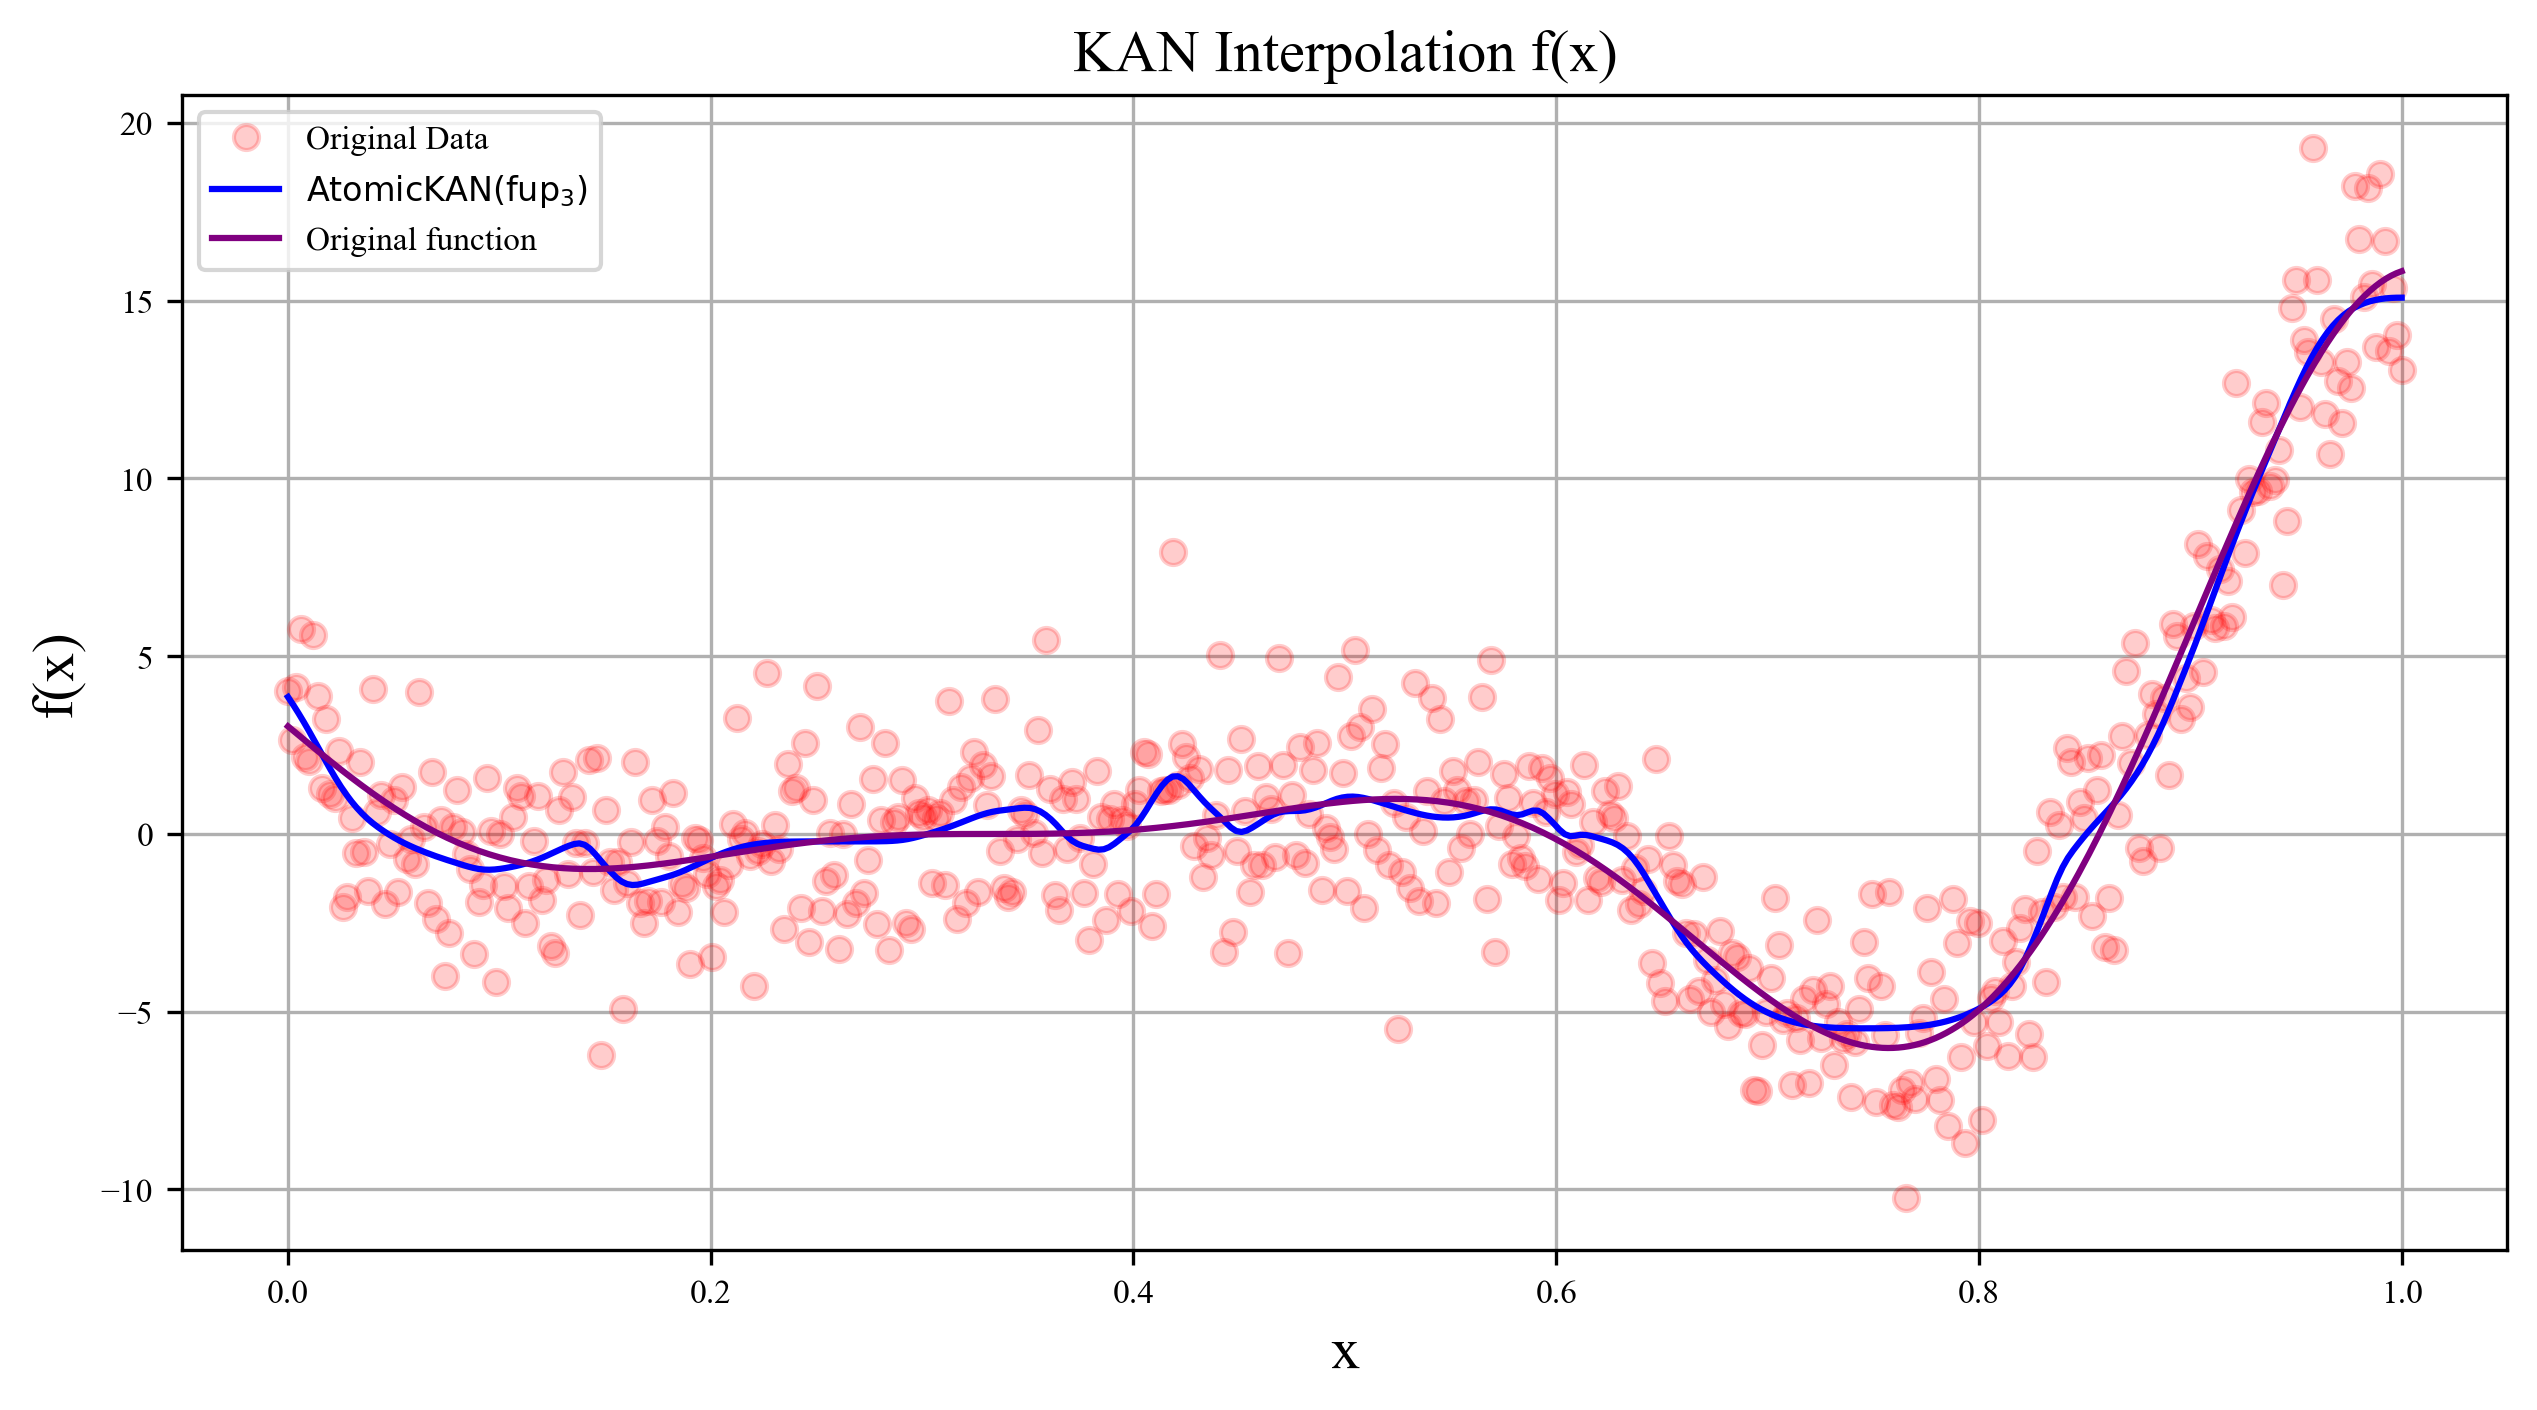

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data', alpha=0.2)
plt.plot(x_test.numpy(), y_pred_atom.numpy(), 'b-', label=r'$\mathrm{AtomicKAN (fup_3)}$')
plt.plot(x_test.numpy(), target_function2(x_test), '-', color='purple', label='Original function')
plt.title('KAN Interpolation f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.show()

In [12]:
class AtomicKANLayer(nn.Module): # UPM function instead of UP
    def __init__(self, input_dim, output_dim, degree, input_range=(-1, 1)):
        super(AtomicKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree
        self.input_range = input_range

        self.atomic_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.atomic_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

        self.register_buffer("centers", torch.linspace(input_range[0], input_range[1], degree + 1))

        center_spacing = (input_range[1] - input_range[0]) / degree
        compression_value = 1.0 / center_spacing

        self.compression = nn.Parameter(torch.ones(degree + 1) * compression_value)

        self.nsum = 100
        self.nprod = 10

    def forward(self, x):
        x = x.view(-1, self.inputdim, 1)
        centers = self.centers.view(1, 1, -1)
        compression = self.compression.view(1, 1, -1)
        scaled_x = (x - centers) * compression

        atomic_basis = upm(scaled_x, m = 5, nsum=self.nsum, nprod=self.nprod) # <-- change this function to other in the file kernel.py!!!

        y = torch.einsum("bid,iod->bo", atomic_basis, self.atomic_coeffs)
        return y.view(-1, self.outdim)

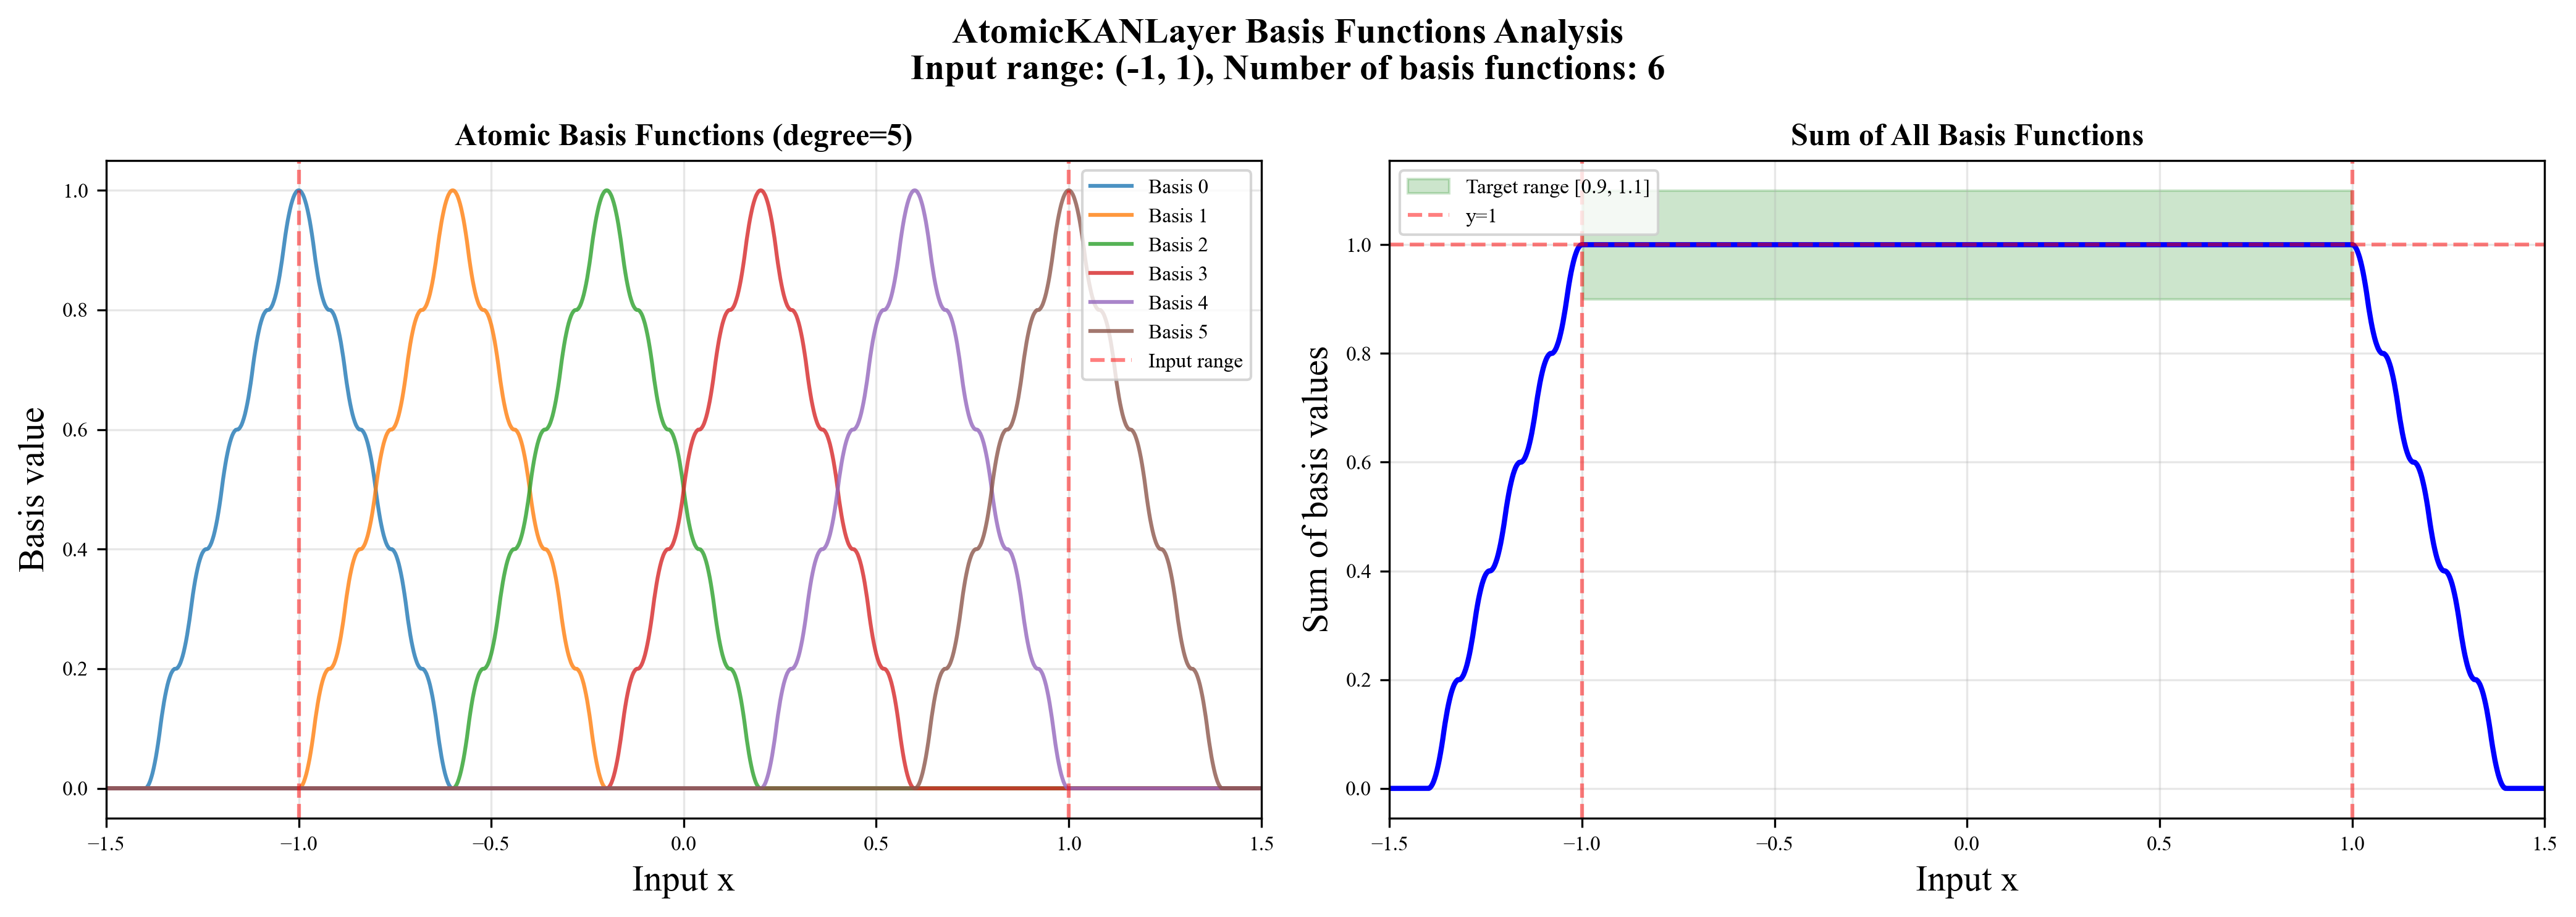

In [13]:
def visualize_atomic_basis():
    # Параметры слоя для визуализации
    input_range = (-1, 1)
    degree = 5  # Количество базисных функций - 1
    nsum = 100
    nprod = 10

    # Создаем слой для анализа
    layer = AtomicKANLayer(
        input_dim=1,  # Для визуализации достаточно 1D входа
        output_dim=1,  # Для визуализации достаточно 1D выхода
        degree=degree,
        input_range=input_range
    )

    # Переводим слой в режим оценки (не обучения)
    layer.eval()

    # Создаем входные данные для визуализации
    x = torch.linspace(input_range[0] - 0.5, input_range[1] + 0.5, 1000)
    x_grid = x.view(-1, 1, 1)  # Формат: (batch, input_dim, 1)

    # Получаем центры и параметры сжатия
    centers = layer.centers.view(1, 1, -1)
    compression = layer.compression.view(1, 1, -1)

    # Вычисляем масштабированные значения
    scaled_x = (x_grid - centers) * compression

    # Вычисляем базисные функции (с torch.no_grad() для отключения градиентов)
    with torch.no_grad():
        atomic_basis = upm(scaled_x, m = 5, nsum=nsum, nprod=nprod)

    # Преобразуем в numpy для визуализации с использованием detach()
    x_np = x.detach().numpy()
    atomic_basis_np = atomic_basis.squeeze().detach().numpy()  # Формат: (1000, degree+1)
    centers_np = layer.centers.detach().numpy()

    # Создаем фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Все базисные функции вместе
    for i in range(degree + 1):
        ax1.plot(x_np, atomic_basis_np[:, i], label=f'Basis {i}', alpha=0.8)
    ax1.axvline(input_range[0], color='r', linestyle='--', alpha=0.5, label='Input range')
    ax1.axvline(input_range[1], color='r', linestyle='--', alpha=0.5)
    ax1.set_title(f'Atomic Basis Functions (degree={degree})', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Input x')
    ax1.set_ylabel('Basis value')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=8)

    # 2. Сумма всех базисных функций (должна быть примерно 1 в рабочей области)
    sum_basis = atomic_basis_np.sum(axis=1)
    ax2.plot(x_np, sum_basis, 'b-', linewidth=2)
    ax2.fill_between(x_np, 0.9, 1.1, where=((x_np >= input_range[0]) & (x_np <= input_range[1])),
                     alpha=0.2, color='green', label='Target range [0.9, 1.1]')
    ax2.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='y=1')
    ax2.axvline(input_range[0], color='r', linestyle='--', alpha=0.5)
    ax2.axvline(input_range[1], color='r', linestyle='--', alpha=0.5)
    ax2.set_title('Sum of All Basis Functions', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Input x')
    ax2.set_ylabel('Sum of basis values')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')

    # Устанавливаем одинаковые пределы по x для обоих графиков
    x_min = input_range[0] - 0.5
    x_max = input_range[1] + 0.5
    ax1.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)

    plt.suptitle(f'AtomicKANLayer Basis Functions Analysis\n'
                 f'Input range: {input_range}, Number of basis functions: {degree + 1}',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Запуск визуализации
visualize_atomic_basis()